In [1]:
import numpy as np
np.random.seed(42)

! Aнсамблирование — это общий термин, обозначающий любую технику, которая создаёт прогнозы путём объединения прогнозов нескольких моделей.

Ансамблевые подходы часто могут повысить производительность одной модели. Ансамблевый подход может помочь снизить:

- Дисперсия путем усреднения нескольких моделей

- Предвзятость, возникающая при итеративном исправлении ошибок

- Переобучение, поскольку использование нескольких моделей может повысить устойчивость к ложным связям

! Почему ансамбль не переобучается, как дерево?

Одно дерево — склонно к переобучению, если дать ему много свободы. В ансамбле каждое дерево переобучается по-своему, но их ошибки не совпадают. При усреднении они взаимно гасятся, а верные сигналы остаются. Статистически в среднем, если у каждого дерева вероятность угадать класс > 0.5, то вместе в среднем чем больше деревьев, тем выше вероятность правильного предсказания. Даже если отдельные деревья переобучены — их ошибки не коррелируют, и итоговое предсказание сглаживает шум.

In [7]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.tree import DecisionTreeClassifier


ds = load_breast_cancer()

clf_x_tr, clf_x_test, clf_y_tr, clf_y_test = train_test_split(ds["data"], ds["target"], test_size=0.2, random_state=42, shuffle=True)

# Bagging и Random Forest

Бэггинг — это особый метод ансамблевого обучения, который используется для уменьшения дисперсии прогностической модели. Дисперсия в смысле машинного обучения - насколько модель меняется при изменении обучающего набора данных. Поскольку бэггинг помогает уменьшить дисперсию модели машинного обучения, он часто улучшает модели с высокой дисперсией (например, деревья решений и KNN), но малоэффективен для моделей с низкой дисперсией (например, линейная регрессия).


Случайный лес - на каждом разбиении дерева выбирается случайное подмножество признаков для лучшего разделения. Дополнительная случайность (выбор признаков) снижает корреляцию между деревьями. Фичи случайны — деревья не просто по-разному обучаются, но и по-разному "смотрят" на данные. Это усиливает разнообразие.

In [8]:
class ClfRandomForest:

    def __init__(self, n_trees: int, **tree_kwargs):
        self.n_trees = n_trees
        self.trees = []
        self.tree_params = tree_kwargs

    
    def fit(self, x: np.array, y: np.array, bootstrap_part: float = 0.5):
        self.classes = sorted(np.unique(y))

        bootstrap_size = int(len(y) * bootstrap_part)

        for _ in range(self.n_trees):
            idx = np.random.randint(0, len(y), size=(bootstrap_size, ))
            tree = DecisionTreeClassifier(**self.tree_params)
            tree.fit(x[idx], y[idx])
            tree.classes = self.classes
            self.trees.append(tree)
    

    def predict(self, x: np.array):
        preds = []
        for tree in self.trees:
            preds.append(tree.predict(x))
        
        probs = []
        for results in np.c_[*preds]:
            classes, counts = np.unique(results, return_counts=True)
            probs_dict = dict(zip(classes, counts / self.n_trees))

            probs.append([probs_dict.get(c, np.float64(0.)) for c in self.classes])
        
        return np.array(probs)

In [9]:
bag = ClfRandomForest(
    n_trees=10, 
    criterion="gini",
    max_depth=3, 
    min_samples_split=10, 
    min_samples_leaf=10,
    max_features=10,  # Если None - Bagging, иначе - Random Forest.
)
bag.fit(clf_x_tr, clf_y_tr)

In [10]:
roc_auc_score(clf_y_test, bag.predict(clf_x_test)[:, 1])

np.float64(0.9970520799213888)

# Boosting

Бустинг - метод ансамблевого обучения. В отличие от бэггинга модели зависят друг от друга. Несколько слабых классификаторов обучаются друг за другом, каждый сосредотачивается на ошибках предыдущих.

Минимизирует экспоненциальную функцию потерь $sum( exp (-y_i * f_i(x)))$. Таким образом мы ошибочные предсказания штрафуем экспоненциально сильнее, чем уверенные правильные. 

AdaBoost - жадный градиентный бустинг по экспоненциальной потере.

### AdaBoost на numpy

In [11]:
class AdaBoost:

    def __init__(self, **tree_kwargs):
        self.clfs = []
        self.alphas = []
        self.tree_params = tree_kwargs
    

    def fit(self, x: np.array, y: np.array, n_clfs: int):
        assert set(np.unique(y)).issubset({-1, 1}), "classes must be only {-1; 1}"
        
        n_samples = len(x)
        w = np.ones(n_samples, dtype=float) / n_samples

        for _ in range(n_clfs):
            # Обучение пня
            tree = DecisionTreeClassifier(**self.tree_params)
            tree.fit(x, y, sample_weight=w)
            
            # Расчет взвешенной ошибки
            preds = tree.predict(x)
            misclassified = (preds != y)
            err = np.sum(w * misclassified)

            # Если дерево работает хуже случайного предсказателя
            if err >= 0.5:
                break
            
            # Вес модели
            alpha = 0.5 * np.log((1 - err) / err)

            # Обновление весов объектов
            w *= np.exp(-alpha * y * preds)
            w /= np.sum(w)

            # Сохранение пня
            self.alphas.append(alpha)
            self.clfs.append(tree)

    
    def _tmp_predict(self, x: np.array):
        preds = np.zeros(shape=(x.shape[0], ))
        for alpha, model in zip(self.alphas, self.clfs):
            preds += alpha * model.predict(x)

        return preds
    

    def predict(self, x: np.array):
        return np.sign(self._tmp_predict(x))
    
    
    def predict_proba(self, x: np.array):
        logits = self._tmp_predict(x)

        probs_pos = 1 / (1 + np.exp(-2 * logits))
        probs_neg = 1 - probs_pos

        return np.c_[probs_neg, probs_pos]

In [ ]:
ab = AdaBoost(criterion="gini", max_depth=1, min_samples_leaf=10, min_samples_split=10)

ab_y_tr = np.copy(clf_y_tr)
ab_y_tr[ab_y_tr == 0] = -1
ab.fit(clf_x_tr, ab_y_tr, n_clfs=50)

ab_y_test = np.copy(clf_y_test)
ab_y_test[ab_y_test == 0] = -1
print("Результаты на test:\n\n", classification_report(ab_y_test, ab.predict(clf_x_test)))
print("ROC-AUC на test:", roc_auc_score(ab_y_test, ab.predict_proba(clf_x_test)[:, 1]).round(3))

Результаты на test:

               precision    recall  f1-score   support

          -1       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

ROC-AUC на test: 0.992


### Gradient Boosting on Decision Trees (GBDT)

Математическая формулировка: при решении задачи регрессии с MSE лосс функцией (L(y, models(x)) = 0.5 * (y - models(x))**2) происходит итеративное приближение функции models к оптимальному решению путем добавления на каждом шаге новой модели. Добавленная модель аппроксимирует отрицательный градиент: 

grad = dLoss/dmodels(x) = (models(x) - y), т.е -grad = y - models(x)

Каждая новая модель обучается на остатках (residuals), что является антиградиентом. 

При использовании другой функции потерь на каждой итерации предсказывается наилучшее смещение в направлении минимизации функции потерь.

In [ ]:
from sklearn.tree import DecisionTreeRegressor


class GBDT:

    def __init__(self, **tree_params):
        self.trees = []
        self.alphas = []
        self.tree_params = tree_params


    def fit(self, x: np.array, y: np.array, n_estimators: int = 50, lr: float = 0.1):
        if len(self.trees) == 0:
            preds = np.zeros_like(y)
        else:
            preds = self.predict(x)
        
        for _ in range(n_estimators):
            residuals = y - preds

            tree = DecisionTreeRegressor(**self.tree_params)
            tree.fit(x, residuals)

            preds += lr * tree.predict(x)

            self.alphas.append(lr)
            self.trees.append(tree)
    

    def predict(self, x: np.array):
        preds = np.zeros(shape=(len(x), ))
        for alpha, tree in zip(self.alphas, self.trees):
            preds += alpha * tree.predict(x)
        
        return preds


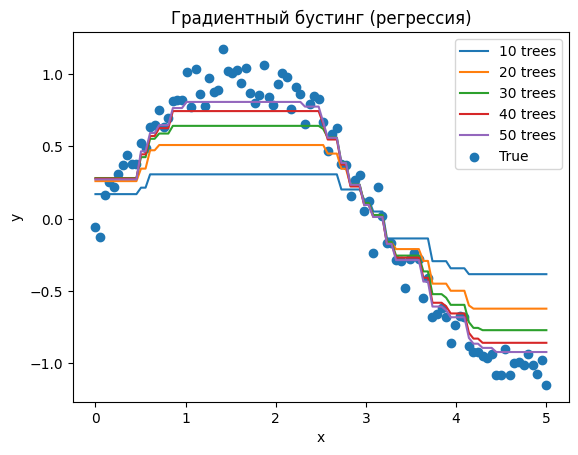

RMSE: 0.122
MEAN y VALUE: 0.138
STD y VALUE: 0.733


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error


X = np.linspace(0, 5, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

gbdt = GBDT(max_depth=2, criterion="squared_error", min_samples_leaf=10, min_samples_split=10)

for i in range(1, 6):
    gbdt.fit(X, y, n_estimators=5)
    plt.plot(X, gbdt.predict(X), label=f"{i * 10} trees")

plt.scatter(X, y, label="True")
plt.legend()
plt.title("Градиентный бустинг (регрессия)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

print(f"RMSE: {root_mean_squared_error(y, gbdt.predict(X)):.3f}")
print(f"MEAN y VALUE: {np.mean(y):.3f}")
print(f"STD y VALUE: {np.std(y):.3f}")

In [25]:
from sklearn.datasets import load_diabetes


ds = load_diabetes(scaled=False)

reg_x_tr, reg_x_test, reg_y_tr, reg_y_test = train_test_split(ds["data"], ds["target"], test_size=0.2, random_state=42, shuffle=True)

gbdt = GBDT(max_depth=2, criterion="squared_error", min_samples_leaf=10, min_samples_split=10)

gbdt.fit(reg_x_tr, reg_y_tr)

print(f"RMSE: {root_mean_squared_error(reg_y_test, gbdt.predict(reg_x_test)):.3f}")
print(f"MEAN y VALUE: {np.mean(reg_y_test):.3f}")
print(f"STD y VALUE: {np.std(reg_y_test):.3f}")

RMSE: 51.527
MEAN y VALUE: 145.775
STD y VALUE: 72.788
